In [10]:
# S1 ############################################################################################ 
# Generiranje kubičnih grafov, priprava in eksport podatkov za nadaljnje analize
# pripravi datoteki:
# Cn_cubic_graph_n10.sobj - generirani grafi
# Cn_all_cubic_graphs.csv - nekatere lastnoszi tgeneriranih grafov, ki jih rabimo za nadalnje analize
# 
# POMEMBNO: če grafi še niso generirani, postavi spremenljivko GENERIRAJ na True, če so grsfi že generirani in želiš
#           priprvait le datoteko csv z lastnostmi grafov, jo postsvi na False
#
from itertools import combinations

GENERIRAJ = False

########################################
# 1) Interval-based indices
########################################

def interval_size(G, u, v):
    du = G.distances(source=u)
    dv = G.distances(source=v)
    d_uv = du[v]
    return sum(1 for w in G.vertices() if du[w] + dv[w] == d_uv)

def Int_index(G):
    dist = G.distance_all_pairs()   # dict-of-dicts
    V = G.vertices()
    s = 0
    for u, v in combinations(V, 2):
        d_uv = dist[u][v]
        # count vertices on some shortest u-v path
        cnt = sum(1 for w in V if dist[u][w] + dist[w][v] == d_uv)
        s += cnt - 1
    return s

def wiener_index(G):
    dist = G.distance_all_pairs()
    return sum(dist[u][v] for u, v in combinations(G.vertices(), 2))

########################################
# 2) Graph classification / properties
########################################

def graph_data(G, graph_id):
    IntG = Int_index(G)
    WG   = wiener_index(G)

    return {
        "id": graph_id,
        "n": G.order(),
        "m": G.size(),
        "planar": G.is_planar(),
        "bipartite": G.is_bipartite(),
        "bridgeless": (G.edge_connectivity() >= 2),
        "girth": G.girth(),
        "radius": G.radius(),
        "diameter": G.diameter(),
        "edge_connectivity": G.edge_connectivity(),
        "vertex_connectivity": G.vertex_connectivity(),
        "automorphism_group_order": G.automorphism_group().order(),
        "chromatic_index": G.chromatic_index(),
        "Int(G)": IntG,
        "Wiener(G)": WG,
        "Int(G)-Wiener(G)": IntG - WG
    }

########################################
# 3) Generate or read cubic graphs
########################################

if GENERIRAJ:
    print(f"Generiranje kubicnih gradov na {n} vozliscih....")
    all_cubic = list(graphs.nauty_geng(f"{n} -c -d3 -D3"))
    save(all_cubic, f"C{n}_cubic_graphs_n10.sobj")
    print(f"File savedC{n}_cubic_graphs_n10.sobj")
else:
    if 'all_cubic' not in globals():
        print(f"Nalaganje grafov iz datoteke C{n}_cubic_graphs_n10.sobj")
        all_cubic = load( f"C{n}_cubic_graphs_n10.sobj")

########################################
# 4) Write CSV
########################################

output_file = f"C{n}_cubic_graphs.csv"
print("Generiranje datoteke ",output_file)
with open(output_file, "w", newline="") as f:
    writer = None

    for i, G in enumerate(all_cubic):
        if i % 1000:
            print(f"prebranih {i}/{N}", flush=True)
        
        row = graph_data(G, i)

        if writer is None:
            # first row = column names
            writer = csv.DictWriter(f, fieldnames=row.keys())
            writer.writeheader()

        writer.writerow(row)

print(f"CSV written to {output_file}")

CSV written to C20_cubic_graphs.csv


In [39]:
# S2 ###########################################
# Naložimo predhodno generirane podatke
#
#!python3 -m pip install pandas
import pandas as pd

n=20

results = pd.read_csv(f"C{n}_cubic_graphs.csv")
if 'all_cubic' not in globals():
    all_cubic  = load(f"C{n}_cubic_graphs_n10.sobj")

print("Load complete, loaded graphs: ", len(results))

Load complete, loaded graphs:  510489


In [9]:
# definiramo Int(G)
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# vzamemo hitrejšo - preveri še enkrat Marijno kodo

def interval_index(G):
    V = G.vertices()  # dobimo vsa vozlišča
    Int_G = 0
    
    # Iteriramo cez  vse pare vozlisc {u, v}
    for u in V:
        for v in V:
            # Izognemo se dvojnemu stetju (u,v) in (v,u) in (u,u)!
            if u >= v:
                continue
            d_uv = G.distance(u, v)    # poiscemo razdaljo
            
            interval_size = 0   # stevec za |I(u,v)|
            
            for w in V:
                d_uw = G.distance(u, w)
                d_wv = G.distance(w, v)
                
                if d_uw + d_wv == d_uv:
                    interval_size += 1
            
            Int_G += (interval_size - 1)
            
    return Int_G

print("Int(G) definirana!")

Int(G) definirana!


There are 510489 non isomorphic cubic graphs on 20 vertices.
Number of vertices: 20
Number of generated graphs: 510489
Int(PathGraph(20) = 1330.


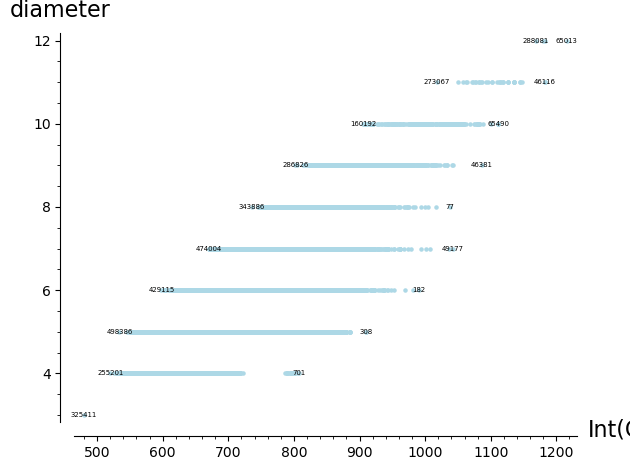

Vseh grafov na diagramu 510489, označenih 19.


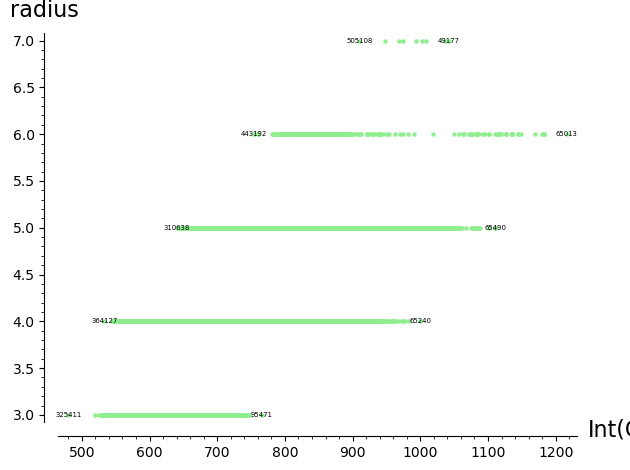

Vseh grafov na diagramu 510489, označenih 10.


In [40]:
# S3 ##########################################################
# narišemo sumarna grafa - v kolikor je treba, predhodno izvedi S1r
# 
import pandas as pd

#########################################
# results: DataFrame z Int(G) in diameter
x = results["Int(G)"]
y = results["diameter"]
num_graphs = len(results)

print(f"There are {num_graphs} non isomorphic cubic graphs on {n} vertices.")
print(f"Number of vertices: {n}")
print(f"Number of generated graphs: {num_graphs}")
vert = interval_index(graphs.PathGraph(n))
print(f"Int(PathGraph({n}) = {vert}.")

# ---- določi točke za označevanje ----

if num_graphs < 1000:
    # označi vse
    label_idx = results.index
else:
    label_idx = []

    # y so cela števila (diameter / radius)
    for y_val in sorted(results["diameter"].unique()):
        subset = results[results["diameter"] == y_val]
        if subset.empty:
            continue
        # min x za ta y
        idx_min = subset["Int(G)"].idxmin()
        # max x za ta y
        idx_max = subset["Int(G)"].idxmax()
        label_idx.append(idx_min)
        if idx_max != idx_min:
            label_idx.append(idx_max)

    label_idx = pd.Index(label_idx).unique()  # odstrani dvojnike

# ---- risanje v Sage ----

# vse točke brez napisov
Gpts = point(list(zip(x, y)), color='lightblue', size=5, faceted=True)

# napisi samo na izbranih indeksih
labels = Graphics()
for i in label_idx:
    xi = results.at[i, "Int(G)"]
    yi = results.at[i, "diameter"]
    labels += text(str(i+1), (xi, yi), color='black', fontsize=5)

p = Gpts + labels
p.axes_labels(['Int(G)', 'diameter'])
p.show()
print(f"Vseh grafov na diagramu {num_graphs}, označenih {len(label_idx)}.")

#######################################
# results: DataFrame z Int(G) in radij
y = results["radius"]

# ---- določi točke za označevanje ----

if num_graphs < 1000:
    # označi vse
    label_idx = results.index
else:
    label_idx = []

    # y so cela števila (diameter / radius)
    for y_val in sorted(results["radius"].unique()):
        subset = results[results["radius"] == y_val]
        if subset.empty:
            continue
        # min x za ta y
        idx_min = subset["Int(G)"].idxmin()
        # max x za ta y
        idx_max = subset["Int(G)"].idxmax()
        label_idx.append(idx_min)
        if idx_max != idx_min:
            label_idx.append(idx_max)

    label_idx = pd.Index(label_idx).unique()  # odstrani dvojnike

# ---- risanje v Sage ----

# vse točke brez napisov
Gpts = point(list(zip(x, y)), color='lightgreen', size=5, faceted=True)

# napisi samo na izbranih indeksih
labels = Graphics()
for i in label_idx:
    xi = results.at[i, "Int(G)"]
    yi = results.at[i, "radius"]
    labels += text(str(i+1), (xi, yi), color='black', fontsize=5)

p = Gpts + labels
p.axes_labels(['Int(G)', 'radius'])
p.show()
print(f"Vseh grafov na diagramu {num_graphs}, označenih {len(label_idx)}.")


20
int(G): 1042   Premer: 7   Radij: 7   Bipartiten: False   Automorf.g.: 256


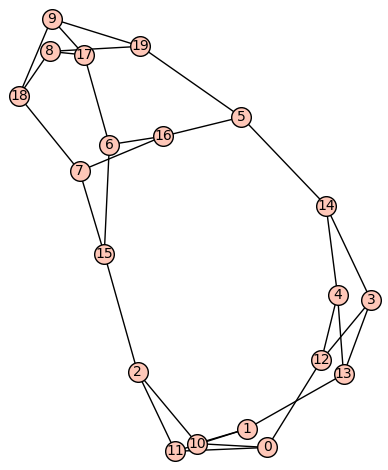

In [50]:
# S3 a ################################################
# izris posameznega grafa
n = 20
print(n)
ind  = 1
ind = ind-1
print("int(G):", results.at[i, "Int(G)"],"  Premer:", results.at[i, "diameter"],  "  Radij:", results.at[i, "radius"], "  Bipartiten:", results.at[i, "bipartite"], "  Automorf.g.:", results.at[i, "automorphism_group_order"])

#print("int(G) :",results.at[i,"Int(G)"], "  Radij: "results.at[i,"radius"])
all_cubic[ind].plot().show()


In [36]:
##################################################
# Nariše in shrani grafe v graph_list v pdf datoteko out_pdf
#
def save_graphs_to_pdf(graph_list, out_pdf,
                       vertex_size=200,
                       base_height=3.2,
                       fig_width=8,
                       layout="circular",
                       fontsize=10):

    m = len(graph_list)

    if m == 0:
        print("Seznam grafov je prazen.")
        return

    if m > 60:
        print(f"Preveliko število grafov za risanje: {m} > 60")
        return

    rows = []
    for i, item in enumerate(graph_list):

        if isinstance(item, tuple):
            ie, g6 = item
            G = Graph(g6, format="graph6")
        else:
            ie = "?"
            G = item
        
        # izračuni lastnosti
        try:
            rad = G.radius()
        except Exception:
            rad = "?"
        try:
            diam = G.diameter()
        except Exception:
            diam = "?"
        try:
            bip = G.is_bipartite()
        except Exception:
            bip = "?"
        try:
            aut = G.automorphism_group().order()
        except Exception:
            aut = "?"

        # izris
        P = G.plot(
            graph_border=False,
            vertex_size=vertex_size,
            layout=layout
        )

        intg = interval_index(G)

        lbl = text(
            f"Ind: {i+1}  int(G): {intg} rad: {rad}   diam: {diam}   bip: {bip}   |Aut|: {aut}",
            (0, -0.35),
            fontsize=fontsize
        )

        rows.append(P + lbl)

    GA = graphics_array(rows, nrows=m, ncols=1)
    GA.save(out_pdf, axes=False, figsize=[fig_width, base_height * m])
    print(f"PDF datoteka '{out_pdf}' uspešno ustvarjena.")


In [5]:
# S4 #####################################################################################
# Statistična obdelava rezultatiov
# Leakage-free Random Forest analysis for Int(G) (Sage-friendly)
# - removes "Wiener(G)" and "Int(G)-Wiener(G)" from features by default
# - also supports predicting the residual Int(G)-Wiener(G) as a separate target

import os
# (recommended) limit native threading to avoid kernel crashes
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

import csv
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance


def load_xy_from_csv(
    filename,
    target_col="Int(G)",
    drop_cols=("id",),
    drop_feature_cols=(),
):
    """
    Load CSV -> (X, y, feature_names)

    - target_col: column to predict
    - drop_cols: columns never used (e.g. id)
    - drop_feature_cols: columns explicitly excluded from FEATURES (e.g. leakage)
    """
    with open(filename, newline="") as f:
        reader = csv.DictReader(f)
        cols = reader.fieldnames
        if cols is None:
            raise ValueError("CSV has no header row.")
        if target_col not in cols:
            raise KeyError(f"Target column '{target_col}' not found. Available: {cols}")

        drop_cols = set(drop_cols)
        drop_feature_cols = set(drop_feature_cols)

        feature_names = [
            c for c in cols
            if (c != target_col) and (c not in drop_cols) and (c not in drop_feature_cols)
        ]

        X_rows, y = [], []
        for row in reader:
            # target
            y.append(float(row[target_col]))

            # features
            feat = []
            for c in feature_names:
                val = row[c]
                if val in ("True", "False"):
                    feat.append(1.0 if val == "True" else 0.0)
                else:
                    # handle Sage "Infinity" if it ever appears
                    if val in ("+Infinity", "Infinity", "inf", "Inf"):
                        feat.append(float("inf"))
                    else:
                        feat.append(float(val))
            X_rows.append(feat)

    X = np.array(X_rows, dtype=float)
    y = np.array(y, dtype=float)

    # If any inf values exist, you must decide how to handle them.
    # For cubic connected graphs, girth/diameter/etc should be finite.
    if not np.isfinite(X).all():
        raise ValueError("Non-finite values (inf/nan) found in features. Clean your CSV or drop those columns.")

    return X, y, feature_names


def rf_analysis_no_leakage(
    csv_file,
    target_col="Int(G)",
    leakage_cols=("Wiener(G)", "Int(G)-Wiener(G)"),
    test_size=0.25,
    random_state=0,
    n_estimators=300,
    n_repeats=10,
):
    """
    Random Forest regression with leakage columns removed from features.

    Returns a dict with model + importances.
    """
    # Force sklearn-friendly base Python types (important in Sage)
    test_size_py = float(test_size) if test_size is not None else None
    rs_py = int(random_state) if random_state is not None else None

    X, y, feature_names = load_xy_from_csv(
        csv_file,
        target_col=target_col,
        drop_cols=("id",),
        drop_feature_cols=leakage_cols,   # <-- leakage removed here
    )

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size_py, random_state=rs_py
    )

    # n_jobs=1 is safest in Sage/Jupyter
    rf = RandomForestRegressor(
        n_estimators=int(n_estimators),
        random_state=rs_py,
        n_jobs=1,
    )
    rf.fit(X_train, y_train)

    r2_train = rf.score(X_train, y_train)
    r2_test  = rf.score(X_test, y_test)

    # Permutation importance (most meaningful)
    perm = permutation_importance(
        rf, X_test, y_test,
        n_repeats=int(n_repeats),
        random_state=rs_py,
        n_jobs=1
    )
    perm_mean = perm.importances_mean
    perm_std  = perm.importances_std

    # Impurity-based importance (can be biased, still useful)
    imp = rf.feature_importances_

    print("=== Random Forest (LEAKAGE REMOVED) ===")
    print(f"File: {csv_file}")
    print(f"Target: {target_col}")
    print(f"Removed leakage cols from features: {list(leakage_cols)}")
    print(f"Samples: {len(y)} | Features used: {len(feature_names)}")
    print(f"R^2 train: {r2_train:.4f}")
    print(f"R^2 test : {r2_test:.4f}\n")

    order_imp = np.argsort(imp)[::-1]
    print("Top features (impurity importance):")
    for k in order_imp[:15]:
        print(f"  {feature_names[k]:30s}  {imp[k]:.6f}")

    order_perm = np.argsort(perm_mean)[::-1]
    print("\nTop features (permutation importance on test set):")
    for k in order_perm[:15]:
        print(f"  {feature_names[k]:30s}  {perm_mean[k]:.6f}  +/- {perm_std[k]:.6f}")

    return {
        "rf": rf,
        "feature_names": feature_names,
        "r2_train": r2_train,
        "r2_test": r2_test,
        "impurity_importance": imp,
        "perm_mean": perm_mean,
        "perm_std": perm_std,
    }


# -----------------------------
# ZAGON STATISTIKE
# -----------------------------

n = 20
csv_file = f"C{n}_cubic_graphs.csv"

# A) Predict Int(G) using ONLY non-leakage properties
out_int = rf_analysis_no_leakage(
    csv_file,
    target_col="Int(G)",
    leakage_cols=("Wiener(G)", "Int(G)-Wiener(G)"),
    test_size=0.25,
    random_state=0,
    n_estimators=300,
    n_repeats=10
)

# B) (Recommended) Predict the "extra geodesic mass" Int(G)-Wiener(G)
#    using classical invariants (this is often more interesting scientifically)
out_extra = rf_analysis_no_leakage(
    csv_file,
    target_col="Int(G)-Wiener(G)",
    leakage_cols=("Int(G)", "Wiener(G)"),  # remove parts that trivially reconstruct the target
    test_size=0.25,
    random_state=0,
    n_estimators=300,
    n_repeats=10
)


=== Random Forest (LEAKAGE REMOVED) ===
File: C20_cubic_graphs.csv
Target: Int(G)
Removed leakage cols from features: ['Wiener(G)', 'Int(G)-Wiener(G)']
Samples: 510489 | Features used: 12
R^2 train: 0.6163
R^2 test : 0.6158

Top features (impurity importance):
  diameter                        0.845595
  radius                          0.074688
  automorphism_group_order        0.041653
  bipartite                       0.027576
  planar                          0.003480
  girth                           0.002765
  vertex_connectivity             0.001483
  edge_connectivity               0.001427
  chromatic_index                 0.001083
  bridgeless                      0.000249
  m                               0.000000
  n                               0.000000

Top features (permutation importance on test set):
  diameter                        0.914039  +/- 0.003486
  radius                          0.097232  +/- 0.000899
  automorphism_group_order        0.069634  +/- 0.000775


In [ ]:
# S5 - OPCIJSKO ####################################################################################
# Combined (multi-n) leakage-free analysis for Int(G) from CSVs:
#   files: C{n}_cubic_graphs.csv for even n in [nMin, nMax]
# Runs RandomForest with:
#   - leakage columns removed from FEATURES
#   - optional normalization of target to reduce size-dominance
#   - option to test on an unseen n (recommended)

import os
# Prevent kernel crashes from OpenMP/BLAS oversubscription (set BEFORE numpy/sklearn import)
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

import csv
import math
import numpy as np
import skearn

from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

# -----------------------------
# User settings
# -----------------------------
nMin = 6
nMax = 18

# Choose ONE target mode:
TARGET_COL = "Int(G)"          # raw target from CSV
NORMALIZE_TARGET = True        # if True: predict Int(G)/C(n,2) instead of Int(G)

# Leakage removal (for predicting Int(G) fairly)
LEAKAGE_COLS = ("Wiener(G)", "Int(G)-Wiener(G)")

# Split mode:
TEST_ON_UNSEEN_N = True        # recommended: hold out one n completely
HELD_OUT_N = nMax              # which n to hold out if TEST_ON_UNSEEN_N=True

# RF parameters (safe in notebooks)
N_ESTIMATORS = 300
N_REPEATS_PI = 10
RANDOM_STATE = 0


# -----------------------------
# Helpers
# -----------------------------
def choose2(n: int) -> int:
    return n * (n - 1) // 2

def file_for_n(n: int) -> str:
    return f"C{n}_cubic_graphs.csv"

def read_rows_with_n(filename: str, n_value: int):
    """Read CSV rows and add an explicit 'n_from_filename'."""
    with open(filename, newline="") as f:
        reader = csv.DictReader(f)
        if reader.fieldnames is None:
            raise ValueError(f"{filename}: missing header row")
        rows = []
        for r in reader:
            r["n_from_filename"] = str(n_value)
            rows.append(r)
        return reader.fieldnames + ["n_from_filename"], rows

def load_combined_data(nMin: int, nMax: int):
    """
    Loads all available C{n}_cubic_graphs.csv (even n).
    Returns (all_rows, all_columns).
    """
    all_rows = []
    all_cols = None

    for n in range(nMin, nMax + 1, 2):
        fn = file_for_n(n)
        if not os.path.exists(fn):
            print(f"[skip] missing file: {fn}")
            continue

        cols, rows = read_rows_with_n(fn, n)
        print(f"[load] {fn}: {len(rows)} rows")

        # Ensure consistent columns across files
        if all_cols is None:
            all_cols = cols
        else:
            # Require same base columns (order can differ; DictReader uses names)
            missing = set(all_cols) - set(cols)
            extra = set(cols) - set(all_cols)
            if missing or extra:
                raise ValueError(
                    f"Column mismatch in {fn}.\nMissing: {missing}\nExtra: {extra}"
                )

        all_rows.extend(rows)

    if all_cols is None:
        raise ValueError("No input files were found/loaded.")

    return all_rows, all_cols

def build_Xy(rows, target_col, leakage_cols, normalize_target=True):
    """
    Build X,y from dict rows:
      - target is Int(G) (raw) or Int(G)/C(n,2) if normalize_target
      - features exclude leakage cols and 'id' (position is index)
      - we include 'n_from_filename' as a feature (important for combined analysis)
    """
    drop_cols = {"id"}  # drop id if present
    leakage_cols = set(leakage_cols)

    # Determine available columns from first row
    cols = list(rows[0].keys())
    if target_col not in cols:
        raise KeyError(f"Target column '{target_col}' not found. Available: {cols}")

    # Feature set
    feature_names = []
    for c in cols:
        if c == target_col:
            continue
        if c in drop_cols:
            continue
        if c in leakage_cols:
            continue
        # Always keep n_from_filename
        feature_names.append(c)

    X = []
    y = []

    for r in rows:
        n_val = int(r["n_from_filename"])
        # target
        t = float(r[target_col])
        if normalize_target:
            t = t / float(choose2(n_val))
        y.append(t)

        # features
        feat = []
        for c in feature_names:
            v = r[c]
            if v in ("True", "False"):
                feat.append(1.0 if v == "True" else 0.0)
            else:
                if v in ("+Infinity", "Infinity", "inf", "Inf", "nan", "NaN", ""):
                    raise ValueError(f"Non-finite value in column '{c}': {v}")
                feat.append(float(v))
        X.append(feat)

    X = np.array(X, dtype=float)
    y = np.array(y, dtype=float)

    return X, y, feature_names

def print_top_importances(feature_names, values, std=None, topk=15, title=""):
    order = np.argsort(values)[::-1]
    if title:
        print(title)
    for k in order[:topk]:
        if std is None:
            print(f"  {feature_names[k]:30s} {values[k]:.6f}")
        else:
            print(f"  {feature_names[k]:30s} {values[k]:.6f} +/- {std[k]:.6f}")


# -----------------------------
# Main: load, split, train, report
# -----------------------------
rows, cols = load_combined_data(nMin, nMax)
X, y, feature_names = build_Xy(
    rows,
    target_col=TARGET_COL,
    leakage_cols=LEAKAGE_COLS,
    normalize_target=NORMALIZE_TARGET
)

# Choose split
rs = int(RANDOM_STATE)

if TEST_ON_UNSEEN_N:
    # Hold out all graphs with n_from_filename == HELD_OUT_N
    n_feat_idx = feature_names.index("n_from_filename")
    n_values = X[:, n_feat_idx].astype(int)

    test_mask = (n_values == int(HELD_OUT_N))
    train_mask = ~test_mask

    X_train, y_train = X[train_mask], y[train_mask]
    X_test, y_test   = X[test_mask],  y[test_mask]

    print(f"\n=== Split: train on n in [{nMin},{nMax}]\\{{{HELD_OUT_N}}}, test on n={HELD_OUT_N} ===")
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=rs
    )
    print("\n=== Split: random 75/25 ===")

print(f"Samples total: {len(y)} | train: {len(y_train)} | test: {len(y_test)}")
print(f"Features used: {len(feature_names)}")
print(f"Target: {TARGET_COL} {'(normalized by C(n,2))' if NORMALIZE_TARGET else '(raw)'}")
print(f"Leakage removed from features: {list(LEAKAGE_COLS)}\n")

# Train RF (safe settings: n_jobs=1)
rf = RandomForestRegressor(
    n_estimators=int(N_ESTIMATORS),
    random_state=rs,
    n_jobs=1
)
rf.fit(X_train, y_train)

r2_train = rf.score(X_train, y_train)
r2_test  = rf.score(X_test, y_test)

print("=== Random Forest (combined n, leakage removed) ===")
print(f"R^2 train: {r2_train:.4f}")
print(f"R^2 test : {r2_test:.4f}\n")

# Importances
imp = rf.feature_importances_
print_top_importances(feature_names, imp, title="Top features (impurity importance):")

perm = permutation_importance(
    rf, X_test, y_test,
    n_repeats=int(N_REPEATS_PI),
    random_state=rs,
    n_jobs=1
)
print()
print_top_importances(feature_names, perm.importances_mean, perm.importances_std,
                      title="Top features (permutation importance on test set):")

# Optional: quick sanity check about the n feature
if "n_from_filename" in feature_names:
    i = feature_names.index("n_from_filename")
    print(f"\nPermutation importance of n_from_filename: {perm.importances_mean[i]:.6f} +/- {perm.importances_std[i]:.6f}")


[run 1/5] seed=0  approx_best=465.50  time=21.4s  topK=16
[run 2/5] seed=1  approx_best=464.31  time=22.6s  topK=19
[run 3/5] seed=2  approx_best=482.12  time=24.3s  topK=13
[run 4/5] seed=3  approx_best=428.69  time=26.6s  topK=17
[run 5/5] seed=4  approx_best=464.31  time=33.7s  topK=16

[done] total_time=128.6s  unique_exact_checked=81

=== GLOBAL BEST (exact) ===
Int(G) = 480
connected = True  diameter = 3  radius = 3 Aut = 20


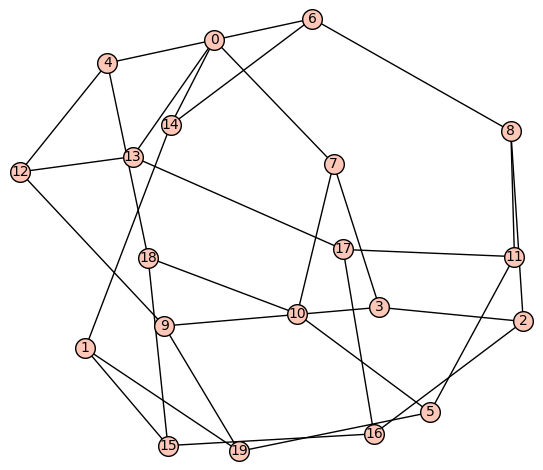


Top 10 (exact):
 1) Int=    480.00  diam= 3  rad= 3  |Aut|=20
 2) Int=    480.00  diam= 3  rad= 3  |Aut|=20
 3) Int=    526.00  diam= 4  rad= 3  |Aut|=4
 4) Int=    534.00  diam= 4  rad= 3  |Aut|=1
 5) Int=    538.00  diam= 4  rad= 3  |Aut|=1
 6) Int=    552.00  diam= 5  rad= 3  |Aut|=2
 7) Int=    552.00  diam= 4  rad= 3  |Aut|=1
 8) Int=    556.00  diam= 4  rad= 3  |Aut|=2
 9) Int=    560.00  diam= 5  rad= 3  |Aut|=2
10) Int=    562.00  diam= 4  rad= 3  |Aut|=1

Top grafi v: C20_multistart.g6
PDF datoteka 'C20_multistart_max_False.pdf' uspešno ustvarjena.

Top 20 grafov izvoženih v pdf: C20_multistart_max_False.pdf


In [38]:
# S6 ###################################################################
# Metaheuristika za kubične grafe: Simulated Annealing + več zagonov (multi-start)
# OPTIMIZIRANO:
#   - Int_sampled_fast uporablja razdaljno matriko (list-of-lists) za manj overhead-a
#   - Int_exact_fast je tudi na matriki (za končno preverjanje top kandidatov)
#   - 2-switch (double-edge swap) ohranja 3-regularnost; opcijsko ohranja povezanost
#
# Zahteva: SageMath (Graph, graphs.RandomRegular, graph6_string)
#

import random, math, time

# -----------------------------
# Nastavitve 
# -----------------------------
#Priporočeni parametri za tvoj XPS 9315 (i7-1250U, 16 GB)
#n = 22–30: steps=30000, mc_samples=8*n .. 12*n, restarts=5
#n = 32–40: steps=15000, mc_samples=6*n .. 10*n, restarts=5..10

n = 20                    
maximize = False           # True -> maximiraj Int(G); False -> minimiziraj Int(G)
keep_connected = True     # ohrani povezanost pri 2-switch potezah

# SA parametri
steps = 30000
T0 = 1.0
alpha = 0.9992
neighbor_tries = 150

# Monte Carlo samples za Int_sampled_fast (priporočilo: 8*n .. 12*n)
mc_samples = 8 * n

# Koliko kandidatov shranjujemo iz vsakega SA zagona za natančno preverjanje
keep_topK = 20

# Število zagonov (multi-start)
restarts = 5
base_seed = 0

# Izvoz top kandidatov (graph6). Nastavi na None, če ne želiš.
export_g6_file = f"C{n}_multistart.g6"
export_file = f"C{n}_multistart_max_{maximize}.pdf"

# ------------------------------------------------------------
# 1) Razdaljna matrika (hitro) + Int_fast
# ------------------------------------------------------------
def dist_matrix(G):
    """
    Vrne (V, idx, D) kjer:
      V   = seznam vozlišč
      idx = slovar vozlišče -> indeks
      D   = matrika razdalj (list of lists), D[i][j] = d(V[i], V[j])
    """
    V = list(G.vertices())
    idx = {v:i for i,v in enumerate(V)}
    # Sage: distance_all_pairs() vrne dict-of-dict
    dd = G.distance_all_pairs()

    nV = len(V)
    D = [[0]*nV for _ in range(nV)]
    for i,u in enumerate(V):
        rowu = dd[u]
        Di = D[i]
        for j,v in enumerate(V):
            Di[j] = rowu[v]
    return V, idx, D

def Int_sampled_fast(G, samples=200):
    """
    Monte Carlo ocena Int(G):
      - naključno izbere `samples` parov (u,v)
      - za vsak par izračuna |I(u,v)|-1 preko matrike razdalj
      - skalarno popravi na C(n,2)
    """
    V, idx, D = dist_matrix(G)
    nV = len(V)
    total_pairs = nV*(nV-1)//2

    acc = 0.0
    # lokalne reference za hitrost
    randrange = random.randrange
    for _ in range(samples):
        i = randrange(nV)
        j = randrange(nV-1)
        if j >= i:
            j += 1

        Dij = D[i][j]
        cnt_minus_1 = -1  # začnemo z -1, potem štejemo w in dobimo (cnt-1)
        Di = D[i]
        # prelet vseh w
        for w in range(nV):
            if Di[w] + D[w][j] == Dij:
                cnt_minus_1 += 1
        acc += cnt_minus_1

    return acc * (total_pairs / float(samples))

def Int_exact_fast(G):
    """
    Natančen Int(G) z razdaljno matriko.
    O(n^3) z nizkim overhead-om (primeren za preverjanje topK, ne za vsako SA iteracijo).
    """
    V, idx, D = dist_matrix(G)
    nV = len(V)
    s = 0
    for i in range(nV):
        Di = D[i]
        for j in range(i+1, nV):
            Dij = Di[j]
            cnt_minus_1 = -1
            for w in range(nV):
                if Di[w] + D[w][j] == Dij:
                    cnt_minus_1 += 1
            s += cnt_minus_1
    return s

# ------------------------------------------------------------
# 2) 2-switch (double-edge swap) sosedstvo
# ------------------------------------------------------------
def two_switch_neighbor(G, max_tries=200, keep_connected=True):
    """
    Poskusi narediti veljavno 2-switch potezo:
      izbere dve povezavi (a,b) in (c,d) ter ju preveže.
    Ohrani enostavnost grafa in 3-regularnost (stopnje se ohranijo).
    """
    edges = list(G.edges(labels=False))
    Eset = set(tuple(sorted(e)) for e in edges)

    for _ in range(max_tries):
        (a,b) = random.choice(edges)
        (c,d) = random.choice(edges)
        if len({a,b,c,d}) < 4:
            continue

        if random.random() < 0.5:
            e1, e2 = (a,c), (b,d)
        else:
            e1, e2 = (a,d), (b,c)

        e1 = tuple(sorted(e1))
        e2 = tuple(sorted(e2))

        # brez zank
        if e1[0] == e1[1] or e2[0] == e2[1]:
            continue
        # brez paralelnih povezav
        if e1 in Eset or e2 in Eset:
            continue

        G2 = G.copy()
        G2.delete_edge(a,b)
        G2.delete_edge(c,d)
        G2.add_edge(*e1)
        G2.add_edge(*e2)

        if keep_connected and not G2.is_connected():
            continue

        return G2, True

    return G, False

# ------------------------------------------------------------
# 3) SA + shranjevanje topK kandidatov (po score_fun)
# ------------------------------------------------------------
def sa_optimize(G0, score_fun, steps, T0, alpha, maximize=True,
                keep_connected=True, neighbor_tries=200, keep_topK=10):
    """
    SA optimizacija z score_fun (tipično Int_sampled_fast).
    Shranjuje topK kandidatov (g6) za kasnejšo natančno evaluacijo.
    """
    G = G0.copy()
    cur = score_fun(G)
    bestG = G.copy()
    best = cur

    top = []       # list (score, g6)
    seen = set()   # g6 deduplikacija

    def store(Gx, sx):
        g6 = Gx.graph6_string()
        if g6 in seen:
            return
        seen.add(g6)
        top.append((sx, g6))
        top.sort(key=lambda t: t[0], reverse=maximize)
        if len(top) > keep_topK:
            # odstranimo odvečne
            for _, old_g6 in top[keep_topK:]:
                seen.discard(old_g6)
            del top[keep_topK:]

    store(G, cur)

    T = float(T0)
    exp = math.exp
    rand = random.random

    for _ in range(steps):
        G2, ok = two_switch_neighbor(G, max_tries=neighbor_tries, keep_connected=keep_connected)
        if not ok:
            T *= alpha
            continue

        s2 = score_fun(G2)
        delta = (s2 - cur) if maximize else (cur - s2)

        if delta >= 0:
            G, cur = G2, s2
        else:
            if rand() < exp(delta / T):
                G, cur = G2, s2

        # global best
        if (maximize and cur > best) or ((not maximize) and cur < best):
            bestG = G.copy()
            best = cur

        store(G, cur)
        T *= alpha

    return bestG, best, top

# ------------------------------------------------------------
# 4) Multi-start 
# ------------------------------------------------------------
def random_connected_cubic(n):
    G = graphs.RandomRegular(3, n)
    while not G.is_connected():
        G = graphs.RandomRegular(3, n)
    return G

def multistart_search():
    global_best_exact = None
    global_best_g6 = None
    all_exact = []  # (exactInt, g6)

    t_all0 = time.time()

    for r in range(restarts):
        seed = int(base_seed) + int(r)
        random.seed(seed)

        G0 = random_connected_cubic(n)

        # score za SA: približek
        score_fun = lambda H: Int_sampled_fast(H, samples=mc_samples)

        t0 = time.time()
        _, bestS, top = sa_optimize(
            G0, score_fun,
            steps=steps, T0=T0, alpha=alpha,
            maximize=maximize,
            keep_connected=keep_connected,
            neighbor_tries=neighbor_tries,
            keep_topK=keep_topK
        )
        t1 = time.time()
        print(f"[run {r+1}/{restarts}] seed={seed}  approx_best={bestS:.2f}  time={t1-t0:.1f}s  topK={len(top)}")

        # natančno preveri topK
        for s, g6 in top:
            H = Graph(g6, format="graph6")
            if keep_connected and not H.is_connected():
                continue
            ie = Int_exact_fast(H)
            all_exact.append((ie, g6))

            if global_best_exact is None:
                global_best_exact, global_best_g6 = ie, g6
            else:
                better = (ie > global_best_exact) if maximize else (ie < global_best_exact)
                if better:
                    global_best_exact, global_best_g6 = ie, g6

    # deduplikacija po g6 in sortiranje po exact
    best_by_g6 = {}
    for ie, g6 in all_exact:
        if (g6 not in best_by_g6) or ((ie > best_by_g6[g6]) if maximize else (ie < best_by_g6[g6])):
            best_by_g6[g6] = ie

    exact_list = [(ie, g6) for g6, ie in best_by_g6.items()]
    exact_list.sort(key=lambda t: t[0], reverse=maximize)

    t_all1 = time.time()
    print(f"\n[done] total_time={t_all1-t_all0:.1f}s  unique_exact_checked={len(exact_list)}")

    G_best = Graph(global_best_g6, format="graph6")
    return G_best, global_best_exact, exact_list

# ------------------------------------------------------------
# 5) Zaženi
# ------------------------------------------------------------
    
G_best, best_exact, exact_list = multistart_search()

print("\n=== GLOBAL BEST (exact) ===")
print("Int(G) =", best_exact)
print("connected =", G_best.is_connected(),
          " diameter =", G_best.diameter(),
          " radius =", G_best.radius(),
          "Aut =", G_best.automorphism_group().order())
G_best.plot().show()
    
print("\nTop 10 (exact):")
for k,(ie,g6) in enumerate(exact_list[:10], start=1):
        H = Graph(g6, format="graph6")
        print(f"{k:2d}) Int={ie:10.2f}  diam={H.diameter():2d}  rad={H.radius():2d}  |Aut|={H.automorphism_group().order()}")
        #H.plot().show()
    
# Izvoz top kandidatov v graph6
if export_g6_file is not None:
        with open(export_g6_file, "w") as f:
            for ie, g6 in exact_list[:max(keep_topK, 50)]:
                f.write(g6 + "\n")
print(f"\nTop grafi v: {export_g6_file}")

# Shranimo kandidate v pdf datoteko
save_graphs_to_pdf(exact_list[:20], export_file, vertex_size=200, base_height=3.2,fig_width=8, layout="spring",  fontsize=10)
print(f"\nTop 20 grafov izvoženih v pdf: {export_file}")




In [37]:
save_graphs_to_pdf(exact_list[:20], export_file, vertex_size=200, base_height=3.2,fig_width=8, layout="spring",  fontsize=10)
print(f"\nTop grafi izvožrni v pdf: {export_file}")

PDF datoteka 'C20_multistart.pdf' uspešno ustvarjena.

Top grafi izvožrni v pdf: C20_multistart.pdf
